# 1. Preparación de Dataset

## Importaciones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re


######## Machine Learning

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier


## 1.1 Preparación de datos

### 1.1.1 Adquisición (Extracción)

In [3]:
BASE_PATH = 'Datawarehouse'
SITIOS_FILE_URL = 'restaurantes.parquet'

df_restaurantes = pd.read_parquet(os.path.join(BASE_PATH, SITIOS_FILE_URL))

### 1.1.2 Transformación

In [4]:
## Origen: 1 si es Maps, 0 si es Yelp
df_restaurantes.loc[:, 'origen'] =  df_restaurantes.loc[:, 'id_restaurante'].apply(lambda x: 1 if len(x) > 22 else 0)
df_restaurantes['id_estado'] = df_restaurantes['id_estado'].apply(lambda x: int(x))

df_restaurantes.sample(1)

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
140336,0x89ddfb76da81de17:0x2c11da1025a146db,32,Stewart's Shops,"['Gas station', 'Alternative fuel station', 'A...",18,42.5182,-73.61829,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.599609,1


In [5]:
def freq(df):
    out = df.value_counts().reset_index()
    out['freq'] = out.iloc[:, 1] / out.iloc[:, 1].sum()
    return out



frecuencias = freq(df_restaurantes['origen'])
google_count = frecuencias.iloc[0, 1]
yelp_count = frecuencias.iloc[1, 1]

atributos_google = pd.DataFrame(pd.json_normalize(df_restaurantes.query("origen == 1").atributos).isna().sum(),columns=['nulos']).sort_values(by="nulos").query(f"nulos <{google_count*.98}").index.tolist()
atributos_yelp = pd.DataFrame(pd.json_normalize(df_restaurantes.query("origen == 0").atributos).isna().sum(),columns=['nulos']).sort_values(by="nulos").query(f"nulos <{yelp_count*.98}").index.tolist()


In [6]:
# df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.contains('Subway')]
# df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.lower().str.contains('subway')]

In [7]:
# nulos > 95738
columnas = pd.DataFrame(pd.json_normalize(df_restaurantes.atributos).isna().sum(),columns=['nulos']).index.to_list()

In [8]:
columnas = ['Accessibility',
 'Amenities',
 'Atmosphere',
 'Crowd',
 'Dining options',
 'Health & safety',
 'Highlights',
 'Offerings',
 'Payments',
 'Popular for',
 'Service options']

### 1. Atributos

In [9]:
atributos = columnas
df_atributos = pd.json_normalize(df_restaurantes.atributos).reset_index()[atributos].fillna(np.ndarray([]))

In [10]:
for col in atributos:
    df_atributos[col] = df_atributos[col].apply(str)
    df_atributos[col] = df_atributos[col].apply(lambda c: "[]" if c == '0.0' else c)
    # df_atributos[col] = df_atributos[col].apply(json.loads)
    

In [11]:
df_atributos.sample(3)

,Accessibility,Amenities,Atmosphere,Crowd,Dining options,Health & safety,Highlights,Offerings,Payments,Popular for,Service options
110166,['Wheelchair accessible entrance' 'Wheelchair ...,['Good for kids' 'Restroom' 'Wi-Fi'],['Casual'],['Family-friendly' 'Groups' 'Tourists'],['Breakfast' 'Lunch' 'Dessert'],[],['Fast service' 'Great coffee'],['Coffee' 'Comfort food' 'Happy hour drinks' '...,['Debit cards' 'NFC mobile payments'],['Breakfast' 'Solo dining' 'Good for working o...,['Delivery' 'Drive-through' 'Takeout' 'Dine-in']
33358,['Wheelchair accessible entrance'],['Good for kids'],['Casual'],['Tourists'],['Lunch' 'Catering'],['Mask required'],[],"['Healthy options' ""Kids' menu"" 'Quick bite' '...",['Debit cards' 'NFC mobile payments'],['Lunch' 'Dinner' 'Solo dining'],['Curbside pickup' 'Takeout' 'Dine-in' 'Delive...
18155,['Wheelchair accessible entrance' 'Wheelchair ...,['Public restroom' 'Wi-Fi'],[],[],[],['Staff get temperature checks'\n 'Staff requi...,[],['Prepared foods'],['Debit cards' 'NFC mobile payments' 'Credit c...,[],['In-store pickup' 'In-store shopping' 'Delive...


In [12]:
# json.loads('["True"]')

In [13]:
# df_atributos['BYOBCorkage'].value_counts()

In [14]:
# atributos

In [15]:
# count = 0
# lineas_json = []

# for a in atributos:
#     for i, row in df_atributos.iterrows():
#         try:            
#             if  type(row[a]) in [int, bool]:
#                 print("entero o bool")
#                 row[a] = json.loads(f"['{row[a]}']")
#                 # lineas_json.append(row[a])
#             elif  row[a] in ["True", "False"]:
#                 # print("True o False")
#                 row[a] = json.loads(f"['{row[a]}']")
#                 # lineas_json.append(row[a])
#             elif  row[a] in ["1", "2", "3", "4", "None"]:
#                 # print("entero o none")
#                 row[a] = json.loads(f"['{row[a]}']")
#                 # lineas_json.append(row[a])
#             elif  row[a] in ["no", "yes_free", "yes_corkage", "u'no'", "u'yes_free'","u'yes_corkage'","None"]:
#                 if row[a].startswith('u'):
#                     try:
#                         row[a] = f'["{row[a][2:-1]}"]'
#                         json.loads(row[a])
#                     except:
#                         print("salio mal", row[a])
#                         json.loads(row[a])
#                 else:
#                     try:
#                         row[a] = f'["{row[a]}"]'        
#                         json.loads(row[a])
#                     except:
#                         print("salio mal", row[a])
#                         print("salio mal")
#             else:
#                 # print("Otro")
#                 row[a] = re.sub(r"'", "\"", row[a])
#                 row[a] = re.sub(r'"\s*"','","', row[a])
#                 row[a] = re.sub(r'"Kids" menu"','"Kids menu"', row[a])
#                 row[a] = json.loads(row[a])
#             lineas_json.append(row)
            
#         except Exception as e:
#             print(i, ": ",row[a], "\n", e)
#             pass

In [16]:
# pd.DataFrame(lineas_json)

In [17]:
# df_atributos

#### 1.2 Accessibility

In [18]:
df_atributos['Accessibility'] = df_atributos['Accessibility'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

df_atributos['Accessibility'].sample(1)

46145    [Wheelchair accessible parking lot, Wheelchair...
Name: Accessibility, dtype: object

In [19]:
columnas_accesibilidad =  df_atributos['Accessibility'].explode().unique()[1:].tolist()


In [20]:
df_accesibilidad = pd.DataFrame([[False] * len(columnas_accesibilidad)] * df_atributos.shape[0], columns=columnas_accesibilidad)

In [21]:
df_accesibilidad.sample(3)

,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,Wheelchair-accessible lift,Assisted listening devices
74290,False,False,False,False,False,False,False,False,False,False,False
30680,False,False,False,False,False,False,False,False,False,False,False
82784,False,False,False,False,False,False,False,False,False,False,False


In [22]:
for i, row in enumerate(df_atributos['Accessibility']):
    for j, val in enumerate(row):
        df_accesibilidad.loc[i, val] = True


In [23]:
df_restaurantes = df_restaurantes.reset_index().reset_index().drop(columns=['index']).rename({'level_0': 'index'}, axis=1, errors='ignore')
df_accesibilidad.reset_index().merge(df_restaurantes, on="index").sample(3)


,index,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
22607,22607,False,False,False,False,False,False,False,False,False,...,0x8640cb3515bc24af:0x9d550b884c8bf38a,43,Angel's Kitchen,['Restaurant'],37,30.031298,-95.440561,"{'AcceptsInsurance': None, 'Accessibility': No...",4.699219,1
31252,31252,True,False,False,False,False,False,False,False,False,...,0x89adca09f148e58b:0x58cfa3d6e4b2cec9,33,Louisburg Nutrition,"['Restaurant', 'Cafe']",15,36.104606,-78.292177,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.800781,1
64305,64305,False,False,False,False,False,False,True,False,False,...,0x80dcdeca68d878bd:0x4396a4a0ab3af5b1,5,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",128,33.707879,-117.855630,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


In [24]:
df_accesibilidad.columns = ["access_" + c for c in df_accesibilidad.columns]
union = df_accesibilidad.reset_index().merge(df_restaurantes, on="index")

In [25]:
union.sample(3)

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible seating,access_Wheelchair accessible restroom,access_Wheelchair accessible elevator,access_Wheelchair-accessible car park,access_Wheelchair-accessible entrance,access_Wheelchair-accessible seating,access_Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
84605,84605,True,False,False,False,False,False,False,False,False,...,0x88d9babc79a4f107:0x52ab1370796c29a2,9,Breadman Miami Bakery,"['Bakery', 'Breakfast restaurant', 'Cake shop'...",278,25.875299,-80.324107,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.500000,1
78420,78420,False,False,False,False,False,False,False,False,False,...,0x8814217cd826698d:0xe9585fe5e3977cc2,14,Red's Pizza & Pasta,"['Pizza restaurant', 'Candy store', 'Pasta sho...",8,41.129462,-85.880114,"{'AcceptsInsurance': None, 'Accessibility': No...",4.398438,1
28831,28831,True,False,False,False,False,False,False,False,False,...,0x89b7a794cc4f75e5:0x36d73ef17c43db0b,20,Cool Runnings Eatery,['Restaurant'],18,38.590888,-76.942948,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.900391,1


In [26]:
df_atributos['Accessibility'].iloc[8536]

[]

#### 1.3 DF Amenities

In [27]:
df_atributos['Amenities'] = df_atributos['Amenities'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_amenities = df_atributos['Amenities'].explode().unique()[1:].tolist()
df_amenities = pd.DataFrame([[False] * len(columnas_amenities)] * df_atributos.shape[0], columns=columnas_amenities)

for i, row in enumerate(df_atributos['Amenities']):
    for j, val in enumerate(row):
        df_amenities.loc[i, val] = True

df_amenities.columns = ["amen_" + c for c in df_amenities.columns]
union = df_amenities.reset_index().merge(union, on="index")

#### 1.4 Atmosphere

In [28]:
df_atributos['Atmosphere'] = df_atributos['Atmosphere'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_atmosphere = df_atributos['Atmosphere'].explode().unique()[1:].tolist()

df_atmosphere = pd.DataFrame([[False] * len(columnas_atmosphere)] * df_atributos.shape[0], columns=columnas_atmosphere)

for i, row in enumerate(df_atributos['Atmosphere']):
    for j, val in enumerate(row):
        df_atmosphere.loc[i, val] = True

df_atmosphere.columns = ["atmos_" + c for c in df_atmosphere.columns]
union = df_atmosphere.reset_index().merge(union, on="index")

#### 1.5 Crowd

In [29]:
df_atributos['Crowd'] = df_atributos['Crowd'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_crowd = df_atributos['Crowd'].explode().unique()[1:].tolist()

df_crowd = pd.DataFrame([[False] * len(columnas_crowd)] * df_atributos.shape[0], columns=columnas_crowd)

for i, row in enumerate(df_atributos['Crowd']):
    for j, val in enumerate(row):
        df_crowd.loc[i, val] = True

df_crowd.columns = ["crowd_" + c for c in df_crowd.columns]
union = df_crowd.reset_index().merge(union, on="index")       

#### 1.6 Dinning Options

In [30]:
df_atributos['Dining options'] = df_atributos['Dining options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_dining = df_atributos['Dining options'].explode().unique()[1:].tolist()
df_dining = pd.DataFrame([[False] * len(columnas_dining)] * df_atributos.shape[0], columns=columnas_dining)

for i, row in enumerate(df_atributos['Dining options']):
    for j, val in enumerate(row):
        df_dining.loc[i, val] = True

df_dining.columns = ["dining_" + c for c in df_dining.columns]
union = df_dining.reset_index().merge(union, on="index")

#### 1.7 Health & safety

In [31]:
df_atributos['Health & safety'] = df_atributos['Health & safety'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_health = df_atributos['Health & safety'].explode().unique()[1:].tolist()

df_health = pd.DataFrame([[False] * len(columnas_health)] * df_atributos.shape[0], columns=columnas_health)

for i, row in enumerate(df_atributos['Health & safety']):
    for j, val in enumerate(row):
        df_health.loc[i, val] = True

df_health.columns = ["health_" + c for c in df_health.columns]
union = df_health.reset_index().merge(union, on="index")        


#### 1.8 Highlights

In [32]:
df_atributos['Highlights'] = df_atributos['Highlights'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_high = df_atributos['Highlights'].explode().unique()[1:].tolist()

df_high = pd.DataFrame([[False] * len(columnas_high)] * df_atributos.shape[0], columns=columnas_high)

for i, row in enumerate(df_atributos['Highlights']):
    for j, val in enumerate(row):
        df_high.loc[i, val] = True

df_high.columns = ["high_" + c for c in df_high.columns]
union = df_high.reset_index().merge(union, on="index")

#### 1.9 Offerings

In [33]:
df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda r: r.replace("Kids'", "Kids"))

df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_offerings = df_atributos['Offerings'].explode().unique()[1:].tolist()

df_offering = pd.DataFrame([[False] * len(columnas_offerings)] * df_atributos.shape[0], columns=columnas_offerings)

for i, row in enumerate(df_atributos['Offerings']):
    for j, val in enumerate(row):
        df_offering.loc[i, val] = True

df_offering.columns = ["offer_" + c for c in df_offering.columns]
union = df_offering.reset_index().merge(union, on="index")

#### 1.10 Payments

In [34]:
df_atributos['Payments'] = df_atributos['Payments'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_payments = df_atributos['Payments'].explode().unique()[1:].tolist()

df_payments = pd.DataFrame([[False] * len(columnas_payments)] * df_atributos.shape[0], columns=columnas_payments)

for i, row in enumerate(df_atributos['Payments']):
    for j, val in enumerate(row):
        df_payments.loc[i, val] = True

df_payments.columns = ["pay_" + c for c in df_payments.columns]
union = df_payments.reset_index().merge(union, on="index")

#### 1.11 Popular for

In [35]:
df_atributos['Popular for'] = df_atributos['Popular for'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_popular = df_atributos['Popular for'].explode().unique()[1:].tolist()

df_popular = pd.DataFrame([[False] * len(columnas_popular)] * df_atributos.shape[0], columns=columnas_popular)

for i, row in enumerate(df_atributos['Popular for']):
    for j, val in enumerate(row):
        df_popular.loc[i, val] = True

df_popular.columns = ["popular_" + c for c in df_popular.columns]
union = df_popular.reset_index().merge(union, on="index")



#### 1.12 Service Options

In [36]:
df_atributos['Service options'] = df_atributos['Service options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_service = df_atributos['Service options'].explode().unique()[1:].tolist()

df_service = pd.DataFrame([[False] * len(columnas_service)] * df_atributos.shape[0], columns=columnas_service)

for i, row in enumerate(df_atributos['Service options']):
    for j, val in enumerate(row):
        df_service.loc[i, val] = True

df_service.columns = ["service_" + c for c in df_service.columns]

union = df_service.reset_index().merge(union, on="index")

In [37]:
union.query("nombre == 'Subway'")

,index,service_Outdoor seating,service_Curbside pickup,service_No-contact delivery,service_Delivery,service_Takeout,service_Dine-in,service_Drive-through,service_In-store pickup,service_In-store shopping,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
156,156,False,False,False,False,False,False,False,False,False,...,gi90NMmRhzl8vzM83UNOVA,9,Subway,"Food, Sandwiches, Restaurants, Fast Food",14,28.150110,-82.353997,"{'AcceptsInsurance': None, 'Accessibility': No...",3.000000,0
296,296,False,False,False,False,False,False,False,False,False,...,wXBAAafoiZ4Nty2ajuBtfw,14,Subway,"Restaurants, Sandwiches, Fast Food",11,39.884360,-86.067905,"{'AcceptsInsurance': None, 'Accessibility': No...",2.500000,0
303,303,False,False,False,False,False,False,False,False,False,...,pFtvNuoUppn9GYx0_ZsW5w,14,Subway,"Sandwiches, Restaurants, Fast Food",6,39.910207,-86.183382,"{'AcceptsInsurance': None, 'Accessibility': No...",2.500000,0
343,343,False,False,False,False,False,False,False,False,False,...,CmDTNEVReN6CgE6ctlZhag,14,Subway,"Sandwiches, Salad, Fast Food, Restaurants",7,39.676701,-86.309883,"{'AcceptsInsurance': None, 'Accessibility': No...",3.000000,0
440,440,False,False,False,False,False,False,False,False,False,...,31s1x27DnN2V-ptUWEdfTQ,14,Subway,"Sandwiches, Restaurants, Fast Food",7,39.912251,-86.261775,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111859,111859,False,False,False,True,True,True,False,False,False,...,0x88179e0e2d642dab:0xb09b943bf4e08e40,22,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",117,42.220565,-85.594977,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.699219,1
111891,111891,False,True,False,True,True,True,False,False,False,...,0x88ff5d3b16bb9a1f:0x957b1d97186d3b2f,40,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",8,33.982629,-80.487539,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.199219,1
111901,111901,False,False,False,True,True,True,False,False,False,...,0x87b2117387ab144d:0x4b2675d40cc8855c,36,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",98,35.434847,-97.562387,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.900391,1
111908,111908,True,False,False,True,True,True,True,False,False,...,0x87d268933b2e8637:0x7690da2187bb74d9,4,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",124,35.377148,-92.223073,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


In [38]:
union.to_parquet("union.parquet")

# 2. Machine Learning

## 2.1 Tareas Previas

### 2.1.1 Importaciones

In [39]:
union

,index,service_Outdoor seating,service_Curbside pickup,service_No-contact delivery,service_Delivery,service_Takeout,service_Dine-in,service_Drive-through,service_In-store pickup,service_In-store shopping,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
0,0,False,False,False,False,False,False,False,False,False,...,MTSW4McQd7CbVtyjqoe9mw,38,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
1,1,False,False,False,False,False,False,False,False,False,...,kfNv-JZpuN6TVNSO6hHdkw,14,Hibachi Express,"Steakhouses, Asian Fusion, Restaurants",20,39.904320,-86.053080,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
2,2,False,False,False,False,False,False,False,False,False,...,sqSqqLy0sN8n2IZrAbzidQ,42,Domino's Pizza,"Pizza, Chicken Wings, Sandwiches, Restaurants",8,36.464747,-86.659187,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
3,3,False,False,False,False,False,False,False,False,False,...,aPNXGTDkf-4bjhyMBQxqpQ,38,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",65,39.962582,-75.135657,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
4,4,False,False,False,False,False,False,False,False,False,...,seKihQKpGGnCeLuELRQPSQ,14,Twin Peaks,"Sports Bars, American (New), American (Traditi...",257,39.906295,-86.047463,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111909,111909,False,True,False,False,True,True,False,False,False,...,0x87d246f0f9aa080f:0x5023e31e61a87f1c,4,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",125,35.491484,-92.034937,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
111910,111910,False,False,False,False,True,False,False,False,False,...,0x87d28d5aa640a9c5:0x3c9cc5d3a99de80c,4,"Simple Simon's Pizza - Vilonia, AR","['Pizza Takeout', 'Italian restaurant', 'Pizza...",38,35.081871,-92.207739,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.500000,1
111911,111911,False,False,False,False,True,False,False,False,False,...,0x88d9dd6e78851851:0x849dcf273582261c,9,Subpreme Grill,"['Sandwich shop', 'Fast food restaurant', 'Tak...",393,25.506121,-80.438215,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1
111912,111912,False,False,False,True,True,True,True,False,False,...,0x89c6c4072624d2a9:0x4437b2d55e9a5811,38,Dunkin',"['Coffee shop', 'Bagel shop', 'Bakery', 'Break...",348,39.923594,-75.245269,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


### 2.1.2 Recorte de Features

Subset de columnas features, que son la columna atributos desplegada

In [40]:
subset = [col for col in union.columns if '_' in col and col not in ['id_restaurante', 'id_estado', 'cantidad_resenas'] ]


Unificación de Features

In [41]:
df = pd.DataFrame(data=None)

# Accesibilidad
df['index'] = union.index
df['access_Wheelchair accessible entrance'] = union['access_Wheelchair accessible entrance'] | union['access_Wheelchair-accessible entrance']
df['access_Wheelchair accessible parking lot'] = union['access_Wheelchair accessible parking lot'] | union['access_Wheelchair-accessible car park']
df['access_Wheelchair accessible restroom'] = union['access_Wheelchair accessible restroom'] | union['access_Wheelchair-accessible toilet']
df['access_Wheelchair accessible seating'] = union['access_Wheelchair accessible seating'] | union['access_Wheelchair-accessible seating']
df['access_Wheelchair accessible elevator'] = union['access_Wheelchair accessible elevator'] | union['access_Wheelchair-accessible lift']

# Amenities
df['amen_Bar onsite'] = union['amen_Bar onsite'] | union['amen_Bar on site']
df['amen_Gender-neutral restroom'] = union['amen_Gender-neutral restroom'] | union['amen_Gender-neutral toilets']
df['amen_Good for kids'] = union['amen_Good for kids']
df['amen_High chairs'] = union['amen_High chairs']
df['amen_Restroom'] = union['amen_Restroom'] | union['amen_Toilets'] | union['amen_Public restroom']
df['amen_Wi-Fi'] = union['amen_Wi-Fi']

# Atmosphere
df['atmos_Cozy'] = union['atmos_Cozy'] | union['atmos_Cosy']
df['atmos_Historic'] = union['atmos_Historic']
df['atmos_Romantic'] = union['atmos_Romantic']
df['atmos_Upscale'] = union['atmos_Upscale']

# Crowd
df['crowd_College students'] = union['crowd_College students']
df['crowd_Family-friendly'] = union['crowd_Family-friendly'] | union['crowd_Family friendly']
df['crowd_Groups'] = union['crowd_Groups']
df['crowd_Locals'] = union['crowd_Locals']
df['crowd_Tourists'] = union['crowd_Tourists']
df['crowd_University students'] = union['crowd_University students']

# Dining
df['dining_Breakfast'] = union['dining_Breakfast']
df['dining_Catering'] = union['dining_Catering']
df['dining_Dessert'] = union['dining_Dessert']
df['dining_Dinner'] = union['dining_Dinner']
df['dining_Lunch'] = union['dining_Lunch']
df['dining_Seating'] = union['dining_Seating']

# Health
df['health_Mask required'] = union['health_Mask required']
df['health_Reservations required'] = union['health_Reservations required']
df['health_Safety dividers at checkout'] = union['health_Safety dividers at checkout']
df['health_Staff get temperature checks'] = union['health_Staff get temperature checks']
df['health_Staff required to disinfect surfaces between visits'] = union['health_Staff required to disinfect surfaces between visits']
df['health_Staff wear masks'] = union['health_Staff wear masks']
df['health_Temperature check required'] = union['health_Temperature check required']

# High

df['high_Fast service'] = union['high_Fast service']
df['high_Great dessert'] = union['high_Great dessert'] | union['high_Great tea selection']
df['high_LGBTQ friendly'] = union['high_LGBTQ friendly'] | union['high_LGBTQ-friendly'] | union['high_Transgender safespace']
df['high_Live music'] = union['high_Live music'] | union['high_Bar games'] | union['high_Fireplace']
df['high_Sports'] = union['high_Sports'] | union['high_Sport']

# Offer
df['offer_Alcohol'] = union['offer_Alcohol'] | union['offer_Hard liquor'] | union['offer_Spirits']
df['offer_Beer'] = union['offer_Beer'] | union['high_Great beer selection']
df['offer_Cocktails'] = union['offer_Cocktails'] | union['high_Great cocktails']
df['offer_Coffee'] = union['offer_Coffee'] | union['high_Great coffee']
df['offer_Comfort food'] = union['offer_Comfort food'] | union['offer_Prepared foods'] | union['offer_Small plates']
df['offer_Food'] = union['offer_Food'] | union['offer_Food at bar'] | union['offer_All you can eat']
df['offer_Halal food'] = union['offer_Halal food']
df['offer_Happy hour drinks'] = union['offer_Happy hour drinks'] | union['offer_Happy-hour drinks']
df['offer_Happy hour food'] = union['offer_Happy hour food'] | union['offer_Happy-hour food']
df['offer_Healthy options'] = union['offer_Healthy options'] | union['offer_Organic dishes']
df['offer_Kids menu'] = union['offer_Kids menu']
df['offer_Quick bite'] = union['offer_Quick bite'] | union['offer_Late-night food']
df['offer_Vegetarian options'] = union['offer_Vegetarian options'] | union['offer_Salad bar']
df['offer_Wine'] = union['offer_Wine'] | union['high_Great wine list']

# Payments

df['pay_Cash-only'] = union['pay_Cash-only']
df['pay_Checks'] = union['pay_Checks']
df['pay_Credit cards'] = union['pay_Credit cards']
df['pay_Debit cards'] = union['pay_Debit cards']
df['pay_NFC mobile payments'] = union['pay_NFC mobile payments']

# Popular

df['popular_Breakfast'] = union['popular_Breakfast']
df['popular_Dinner'] = union['popular_Dinner']
df['popular_Good for working on laptop'] = union['popular_Good for working on laptop']
df['popular_Lunch'] = union['popular_Lunch']
df['popular_Solo dining'] = union['popular_Solo dining']

# Service

df['service_Curbside pickup'] = union['service_Curbside pickup'] | union['service_Drive-through']
df['service_Delivery'] = union['service_Delivery'] | union['service_No-contact delivery']
df['service_Dine-in'] = union['service_Dine-in']
df['service_In-store shopping'] = union['service_In-store shopping'] | union['service_In-store pickup']
df['service_Outdoor seating'] = union['service_Outdoor seating']
df['service_Takeout'] = union['service_Takeout'] | union['service_Takeaway']


In [42]:
# df.to_csv("df_salida_preprocs_cuaderno.csv")
# union.to_csv("union_salida_preprocs_cuaderno.csv")

Seleccionamos las que tienen una tasa de ocurrencia del 0.5% o más

In [43]:
tasa = pd.Series(df.sum()/len(union))
columnas = tasa[tasa >=0.005].index.tolist()
print(f"Columnas de atributos: {len(columnas)} columnas resultantes")

Columnas de atributos: 70 columnas resultantes


In [44]:
columnas_restaurante = pd.Series(union.columns).reset_index().loc[159:,0].tolist()
print(f"Columnas de restaurantes: {len(columnas_restaurante)} columnas de datos restaurantes")

Columnas de restaurantes: 10 columnas de datos restaurantes


DataFrame resultante

In [45]:
df = pd.concat([df, union[columnas_restaurante]], axis=1)
df.sample(3)

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair accessible elevator,amen_Bar onsite,amen_Gender-neutral restroom,amen_Good for kids,amen_High chairs,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
57671,57671,True,True,True,True,False,False,False,True,True,...,0x88033800f7a86701:0xd59ea0a0c15ae72b,49,Culver's,"['American restaurant', 'Dessert restaurant', ...",938,44.074703,-87.700133,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.398438,1
97875,97875,True,True,False,True,False,False,False,True,True,...,0x86458fa9d19a3a8f:0x66aa59088c797bf4,43,Chopsticks,"['Chinese restaurant', 'Restaurant']",78,31.306439,-96.889548,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1
6831,6831,False,False,False,False,False,False,False,False,False,...,Miy9w9lKGL_AzqIMkSvB0g,42,Cheap Charlies Taco Shop,"Food Trucks, Mexican, Food, Restaurants, Tacos",69,36.177784,-86.749796,"{'AcceptsInsurance': None, 'Accessibility': No...",4.500000,0


In [46]:
# encoder.get_feature_names_out(['id_estado'])
# encoder.fit_transform(df[['id_estado']].astype(int))
# encoder.get_feature_names_out()

In [47]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# enc.fit(range(1,51).reshape(-1,1))
# enc.fit(df_restaurantes['id_estado'].reset_index())

one_hot_encoded = encoder.fit_transform(df[['id_estado']].astype(int))
# one_hot_encoded
df_one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())
# df[['id_estado']]

df = pd.concat([df, df_one_hot_encoded], axis=1)

In [48]:
# df

In [49]:
us = union.query("nombre == 'Subway'")

In [50]:
us.query("id_restaurante == '0x865681564f2dfd47:0x1f030438f1ceed23'")

,index,service_Outdoor seating,service_Curbside pickup,service_No-contact delivery,service_Delivery,service_Takeout,service_Dine-in,service_Drive-through,service_In-store pickup,service_In-store shopping,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
111607,111607,False,False,False,True,True,True,False,False,False,...,0x865681564f2dfd47:0x1f030438f1ceed23,43,Subway,"['Sandwich shop', 'Fast food restaurant', 'Tak...",8,32.610581,-99.819431,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.099609,1


In [51]:
# us = union.query("nombre == 'Subway'")

# columnas_service = [col for col in us.columns if col.startswith('service')]

# with open('us_service_sql.txt', 'w') as f:
#     for i, row in us.iterrows():
#         for c in columnas_service:
#             if us.loc[i, c] == 1:
#                 f.write(f"('{us.loc[i,'id_restaurante']}', '{c[8:]}');\n")

In [52]:
# columnas_service = [col for col in df_atributos_filtrado.columns if col.startswith('service')]

# columnas_access = [col for col in df_atributos_filtrado.columns if col.startswith('access')]
# columnas_amen = [col for col in df_atributos_filtrado.columns if col.startswith('amen')]
# columnas_atmos = [col for col in df_atributos_filtrado.columns if col.startswith('atmos')]
# columnas_crowd = [col for col in df_atributos_filtrado.columns if col.startswith('crowd')]
# columnas_dining = [col for col in df_atributos_filtrado.columns if col.startswith('dining')]
# columnas_health = [col for col in df_atributos_filtrado.columns if col.startswith('health')]
# columnas_high = [col for col in df_atributos_filtrado.columns if col.startswith('high')]
# columnas_offer = [col for col in df_atributos_filtrado.columns if col.startswith('offer')]
# columnas_pay = [col for col in df_atributos_filtrado.columns if col.startswith('pay')]
# columnas_popular = [col for col in df_atributos_filtrado.columns if col.startswith('popular')]


# with open('service_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_service:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[8:]}');\n")

# with open('access_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_access:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n")

# with open('amenities_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_amen:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[5:]}');\n")                

# with open('atmosphere_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_atmos:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n")          

# with open('crowd_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_crowd:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n") 

# with open('dining_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_dining:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n") 

# with open('health_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_health:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n")

# with open('high_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_high:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[5:]}');\n")

# with open('offer_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_offer:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n")

# with open('pay_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_pay:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[4:]}');\n")

# with open('popular_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_popular:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[8:]}');\n")


In [53]:
# import pandas as pd

# # Definir las categorías y las correspondientes subcadenas de corte
# categorias = {
#     'service': 8,
#     'access': 7,
#     'amen': 5,
#     'atmos': 6,
#     'crowd': 6,
#     'dining': 7,
#     'health': 7,
#     'high': 5,
#     'offer': 6,
#     'pay': 4,
#     'popular': 8
# }

# # # Filtrar columnas por cada categoría
# columnas = {cat: [col for col in us.columns if col.startswith(cat)] for cat in categorias.keys()}

# chunk_size = 500
# queries = []
# id_counter = 1  # Asegúrate de inicializar el contador

# with open('us_inserts_atributos.sql', 'w') as f:
#     for cat, substr_len in categorias.items():
#         for i, row in us.iterrows():
#             for col in columnas[cat]:
#                 if us.loc[i, col] == 1:
#                     query = f"({id_counter}, '{us.loc[i,'id_restaurante']}', '{cat}', '{col[substr_len:]}')"
#                     queries.append(query)
#                     id_counter += 1

#                     # Escribir al archivo en chunks de 100 consultas
#                     if len(queries) >= chunk_size:
#                         f.write("INSERT INTO atributos VALUES " + ", ".join(queries) + ";\n")
#                         queries = []  # Vaciar la lista de consultas

#     # Escribir cualquier consulta restante en la lista
#     if queries:
#         f.write("INSERT INTO atributos VALUES " + ", ".join(queries) + ";\n")

### 2.1.3 Downgrade de calificacion

Preparación del umbral, que divida a la calificación de positiva a negativa.

[]

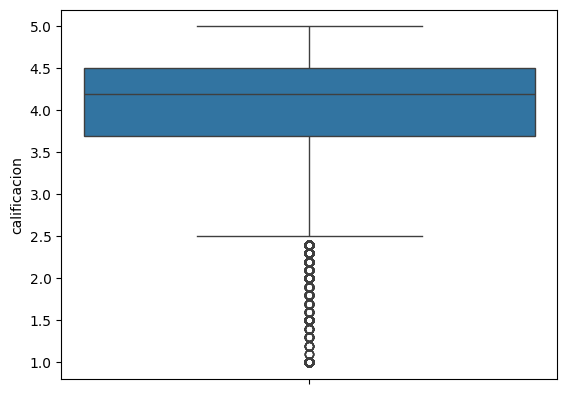

In [54]:
fig = sns.boxplot(df_restaurantes['calificacion'])
fig.plot()

In [55]:
df['calificacion'].describe()

count    111914.000000
mean          4.053937
std           0.665589
min           1.000000
25%           3.699219
50%           4.199219
75%           4.500000
max           5.000000
Name: calificacion, dtype: float64

Decidimos utilizar el promedio como umbral

In [56]:
umbral = df['calificacion'].mean()

In [57]:
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].apply(lambda x: 1 if x >= umbral else 0)

In [58]:
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].astype(int)

### 2.1.4 Selección de Features para el ML

In [59]:
dropear = ["nombre","index", "id_restaurante","categorias", "id_estado", "atributos", "cantidad_resenas"]
# dropear = ["index", "id_restaurante","categorias", "atributos", "nombre"]

df = df.loc[:, ~df.columns.isin(dropear)]



### 2.1.5 Over y Under Sampling

In [60]:
df['calificacion'].value_counts()

calificacion
1.0    62971
0.0    48943
Name: count, dtype: int64

In [61]:
df = pd.concat([df.query("calificacion == 1").sample(48943),df.query("calificacion == 0")])

In [62]:
df['calificacion'].value_counts()

calificacion
1.0    48943
0.0    48943
Name: count, dtype: int64

In [63]:
df[df.columns[:-53]] = df[df.columns[:-53]].astype(int)

In [64]:
df.to_parquet('df.parquet')

In [65]:
df

,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair accessible elevator,amen_Bar onsite,amen_Gender-neutral restroom,amen_Good for kids,amen_High chairs,amen_Restroom,...,id_estado_41,id_estado_42,id_estado_43,id_estado_44,id_estado_45,id_estado_46,id_estado_47,id_estado_48,id_estado_49,id_estado_50
75391,1,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82875,1,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49761,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50639,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22526,1,1,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111901,1,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111904,1,1,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111905,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111908,1,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
# X_subway = df.query("nombre == 'Subway'").drop(['calificacion', 'nombre'], axis=1)
# y_subway = df.query("nombre == 'Subway'").loc[:, 'calificacion']
# X_nsubway = df.query("nombre != 'Subway'").drop(['calificacion', 'nombre'], axis=1)
# y_nsubway = df.query("nombre != 'Subway'").loc[:, 'calificacion']

# X_train, X_test, y_train, y_test = X_nsubway, X_subway, y_nsubway, y_subway

## 2.2 Modelos

In [59]:
scores = dict()

X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

### 2.2.1 Prueba de Regresores: Regresión Logística, RandomForest, HistGradientBoostin, XGBClassifier, Kneighbors, GradientBoosting

Scaler: StandardScaler, Classifier: RandomForestClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=  20.9s
Accuracy: 0.7417
Scaler: StandardScaler, Classifier: LogisticRegression
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   1.1s
Accuracy: 0.7242
Scaler: StandardScaler, Classifier: HistGradientBoostingClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   4.9s
Accuracy: 0.7451


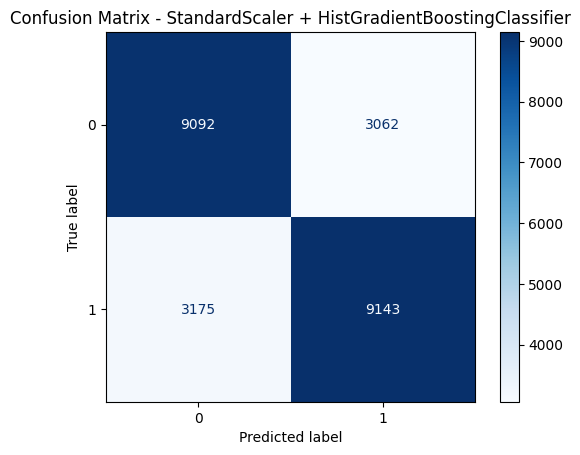

Scaler: StandardScaler, Classifier: XGBClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   1.3s
Accuracy: 0.7468


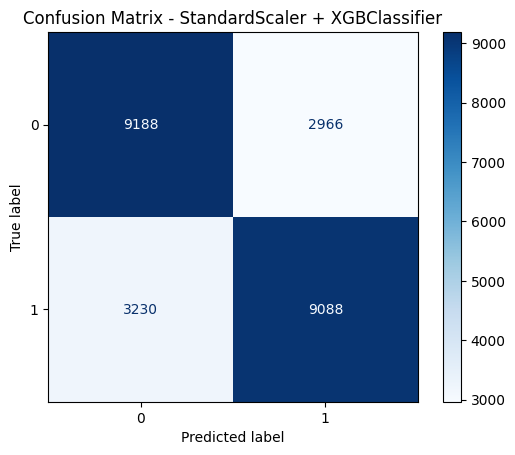

Scaler: StandardScaler, Classifier: KNeighborsClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   0.1s
Accuracy: 0.7058
Scaler: StandardScaler, Classifier: GradientBoostingClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=  18.3s
Accuracy: 0.7308
Scaler: MaxAbsScaler, Classifier: RandomForestClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=  17.8s
Accuracy: 0.7402
Scaler: MaxAbsScaler, Classifier: LogisticRegression
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   0.7s
Accuracy: 0.7232
Scaler: MaxAbsScaler, Classifier: HistGradientBoostingClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1

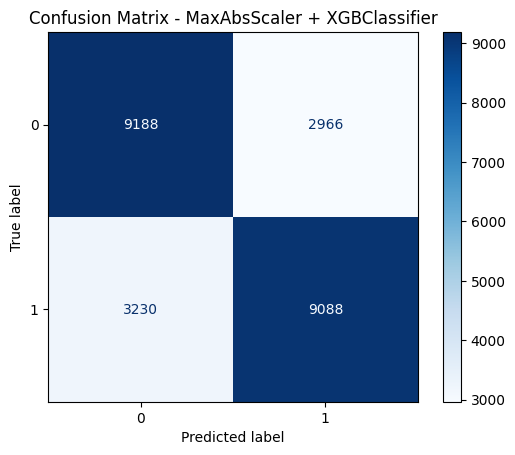

Scaler: MaxAbsScaler, Classifier: KNeighborsClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   0.0s
Accuracy: 0.7175
Scaler: MaxAbsScaler, Classifier: GradientBoostingClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=  18.5s
Accuracy: 0.7308
Scaler: MinMaxScaler, Classifier: RandomForestClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=  17.4s
Accuracy: 0.7406
Scaler: MinMaxScaler, Classifier: LogisticRegression
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   0.8s
Accuracy: 0.7239
Scaler: MinMaxScaler, Classifier: HistGradientBoostingClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[P

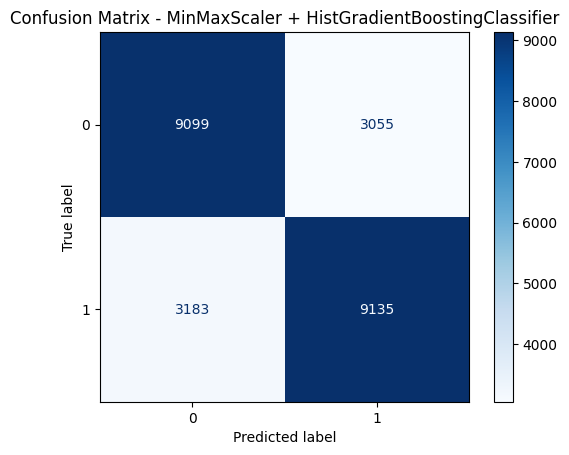

Scaler: MinMaxScaler, Classifier: XGBClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   1.0s
Accuracy: 0.7468


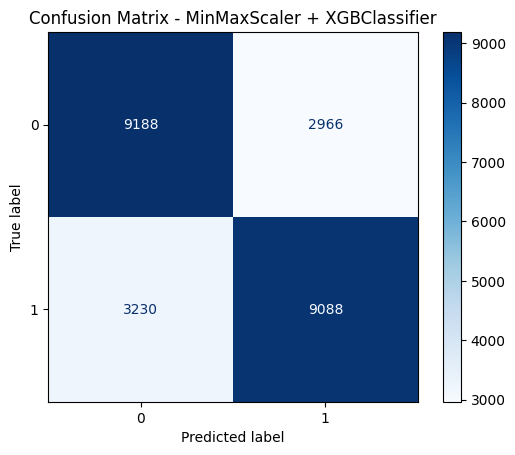

Scaler: MinMaxScaler, Classifier: KNeighborsClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=   0.1s
Accuracy: 0.7180
Scaler: MinMaxScaler, Classifier: GradientBoostingClassifier
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clasiffier, total=  18.6s
Accuracy: 0.7308


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scalers = [StandardScaler(), MaxAbsScaler(), MinMaxScaler()]
classifiers = [RandomForestClassifier(), LogisticRegression(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'), KNeighborsClassifier(), GradientBoostingClassifier()]

for s in scalers:
    for c in classifiers:
        print(f"Scaler: {s.__class__.__name__}, Classifier: {c.__class__.__name__}")
        pipe = Pipeline([('scaler', s), ('clasiffier', c)], verbose=True)
        pipe.fit(X_train, y_train)  # apply scaling on training data
        # scores["HistGradientBoostingClassifier"] = pipe.score(X_test, y_test)
        # Print the accuracy score
        score = pipe.score(X_test, y_test)
        print(f"Accuracy: {score:.4f}")

        if score >= 0.745:
            cm = confusion_matrix(y_test, pipe.predict(X_test))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap='Blues')
            # disp = ConfusionMatrixDisplay.from_estimator(c, X_test, y_test, cmap='viridis', display_labels=pipe.classes_)
            # disp.plot()
            plt.title(f"Confusion Matrix - {s.__class__.__name__} + {c.__class__.__name__}")
            plt.show()
# print(classification_report(y_test, pipe.predict(X_test)))

Decidiendo Utilizar XGBoosting y StandardScaler procedemos a afinar parámetros

In [63]:
# Supongamos que X y y son tus datos y etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Definir el rango de hiperparámetros a buscar
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Imprimir los mejores hiperparámetros
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Evaluar el modelo en los datos de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")


Best parameters: {'xgb__colsample_bytree': 0.9, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best cross-validation score: 0.7535883995219848
Test accuracy: 0.75


In [73]:
# Supongamos que X y y son tus datos y etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'subsample': 0.8}

# Crear el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ('xgb', XGBClassifier(**params))
])

pipeline.fit(X_test, y_test)

# Definir el rango de hiperparámetros a buscar

# Evaluar el modelo en los datos de prueba
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))



Test accuracy: 0.83
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      9672
           1       0.83      0.83      0.83      9906

    accuracy                           0.83     19578
   macro avg       0.83      0.83      0.83     19578
weighted avg       0.83      0.83      0.83     19578



In [65]:
grid_search.best_params_

{'xgb__colsample_bytree': 0.9,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.8}

In [74]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

joblib.dump(pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [75]:
with open('model_params.json', 'w') as f:
    json.dump(params, f)

In [77]:
# Cargar el pipeline desde el archivo
loaded_pipeline = joblib.load('model_pipeline.pkl')

# Cargar los hiperparámetros desde el archivo JSON
with open('model_params.json', 'r') as f:
    loaded_params = json.load(f)

print("Loaded parameters:", loaded_params)

# Evaluar el modelo cargado en los datos de prueba
y_pred = loaded_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print(f"Test accuracy: {accuracy:.2f}")


Loaded parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
[1 0 0 ... 0 1 1]
Test accuracy: 0.83


Mejores hiperparámetros: {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga'}


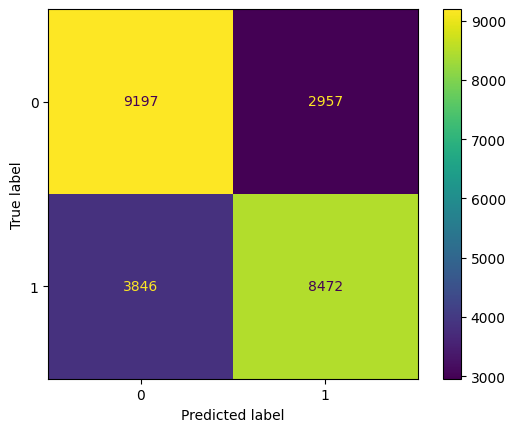

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     12154
           1       0.74      0.69      0.71     12318

    accuracy                           0.72     24472
   macro avg       0.72      0.72      0.72     24472
weighted avg       0.72      0.72      0.72     24472

Validación: 0.7943828645043555
Train: 0.7958145133655704


In [163]:

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Crear una tubería (pipeline) con el escalador y el modelo de regresión logística
pipe = make_pipeline(StandardScaler(), LogisticRegression())

model = LogisticRegression()

param_grid = {
    'logisticregression__C': [0.1],
    # 'logisticregression__penalty': ['l2', None],
    'logisticregression__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    # 'logisticregression__max_iter': [100, 200, 300],
    # 'logisticregression__tol': [1e-4, 1e-3, 1e-2],
    'logisticregression__class_weight': ['balanced'],
    'logisticregression__fit_intercept': [True]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')

# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_pipe = grid_search.best_estimator_

# Guardar las puntuaciones
scores = dict()
scores["Logistic Regression"] = best_pipe.score(X_test, y_test)

# Matriz de confusión
cm = confusion_matrix(y_test, best_pipe.predict(X_test))

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_test, best_pipe.predict(X_test)))

# Validación cruzada
results = cross_validate(best_pipe, X_train, y_train, cv=5, return_train_score=True, scoring='roc_auc')

print('Validación:', results['test_score'].mean())
print('Train:', results['train_score'].mean())


0.7412553121935272


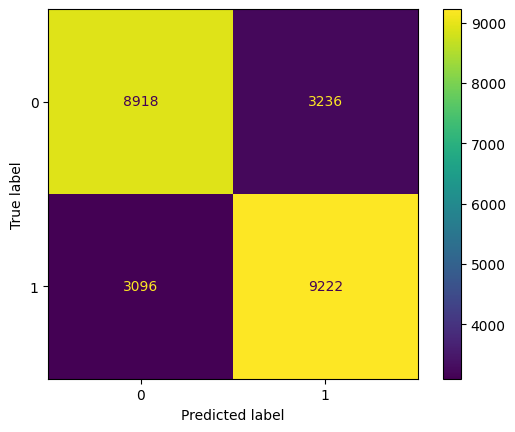

              precision    recall  f1-score   support

           0       0.74      0.73      0.74     12154
           1       0.74      0.75      0.74     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [164]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe = make_pipeline(MaxAbsScaler(), LogisticRegression())
# pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1))

pipe.fit(X_train, y_train)  # apply scaling on training data
scores["Random Forest Classifier"]= pipe.score(X_test, y_test)


print(pipe.score(X_test, y_test))  # 

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))

0.7430532853873815


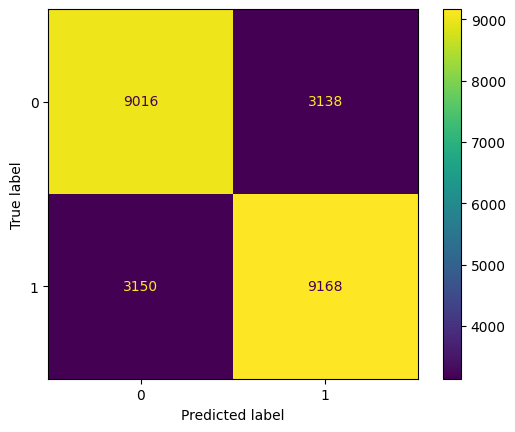

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     12154
           1       0.75      0.74      0.74     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [165]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe = make_pipeline(MaxAbsScaler(), LogisticRegression())
pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1))

pipe.fit(X_train, y_train)  # apply scaling on training data
scores["HistGradientBoostingClassifier"] = pipe.score(X_test, y_test)

print(pipe.score(X_test, y_test))  # 

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))

In [166]:

# X = df.drop(['calificacion'], axis=1)
# y = df['calificacion'] 

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_reg = reg_model.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_reg)



print(f'Mean Squared Error (Regresión): {mse}')

# Modelo de clasificación
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train)
y_pred_clf = clf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_clf)
print(f'Accuracy (Clasificación): {accuracy}')
scores["Random Forest 2"] = accuracy_score(y_test, y_pred_clf)
random_forest_accuracy = accuracy


# Print classification report
print(classification_report(y_test, y_pred_clf))


Mean Squared Error (Regresión): 0.18830886726601237
Accuracy (Clasificación): 0.7425220660346519
              precision    recall  f1-score   support

           0       0.74      0.73      0.74     12154
           1       0.74      0.75      0.75     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [167]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Supongamos que df es tu DataFrame y 'calificacion' es la columna objetivo dicotómica

# # Dividir las características y la variable objetivo
# X = df.drop(['calificacion'], axis=1)
# y = df['calificacion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred = log_reg.predict(X_test_scaled)

# Calcular la precisión y otros métricos
accuracy = accuracy_score(y_test, y_pred)
scores["Logistic Regression 2"] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.7231586474614363
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      9672
           1       0.75      0.69      0.72      9906

    accuracy                           0.72     19578
   macro avg       0.72      0.72      0.72     19578
weighted avg       0.72      0.72      0.72     19578

Confusion Matrix:
[[7347 2325]
 [3095 6811]]


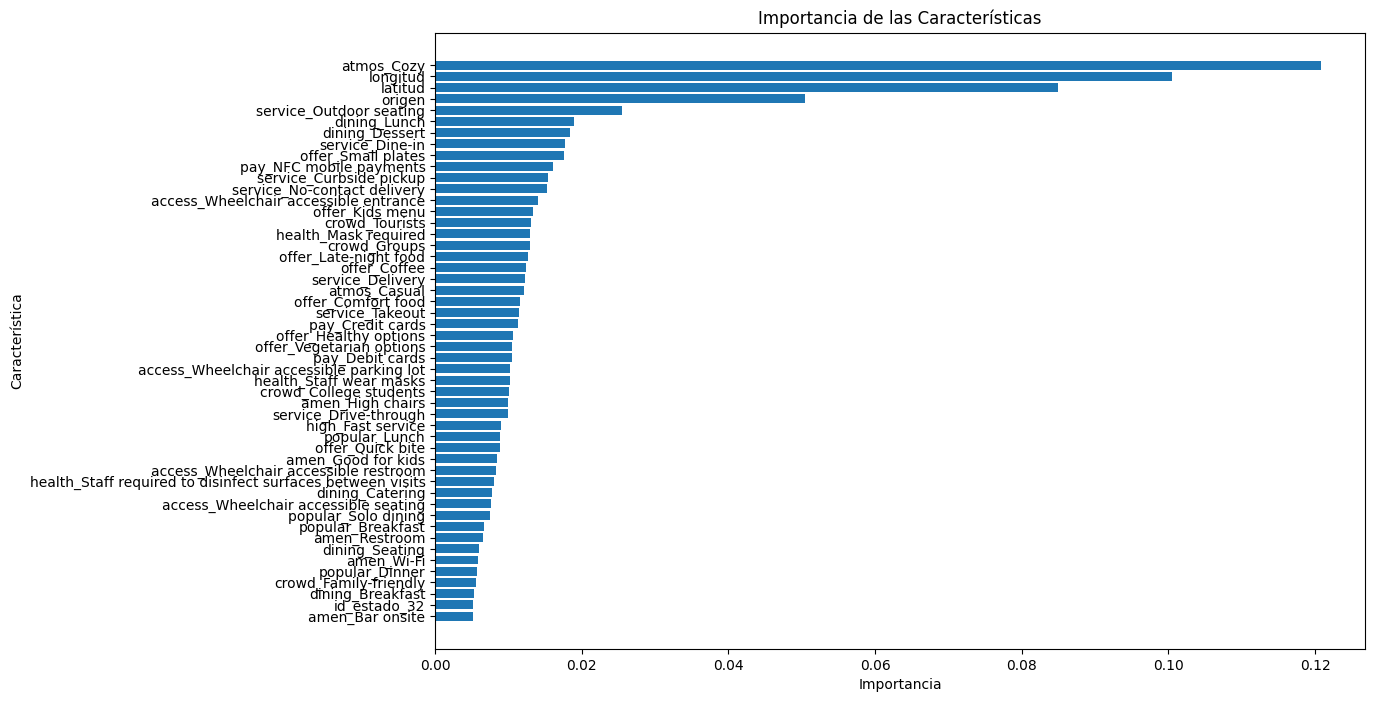

['atmos_Cozy', 'longitud', 'latitud', 'origen', 'service_Outdoor seating', 'dining_Lunch', 'dining_Dessert', 'service_Dine-in', 'offer_Small plates', 'pay_NFC mobile payments', 'service_Curbside pickup', 'service_No-contact delivery', 'access_Wheelchair accessible entrance', 'offer_Kids menu', 'crowd_Tourists', 'health_Mask required', 'crowd_Groups', 'offer_Late-night food', 'offer_Coffee', 'service_Delivery', 'atmos_Casual', 'offer_Comfort food', 'service_Takeout', 'pay_Credit cards', 'offer_Healthy options', 'offer_Vegetarian options', 'pay_Debit cards', 'access_Wheelchair accessible parking lot', 'health_Staff wear masks', 'crowd_College students', 'amen_High chairs', 'service_Drive-through', 'high_Fast service', 'popular_Lunch', 'offer_Quick bite', 'amen_Good for kids', 'access_Wheelchair accessible restroom', 'health_Staff required to disinfect surfaces between visits', 'dining_Catering', 'access_Wheelchair accessible seating', 'popular_Solo dining', 'popular_Breakfast', 'amen_Res

In [168]:

model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar las características por importancia
features = features.sort_values(by='Importance', ascending=False).head(50)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()

print(features['Feature'].tolist())

Accuracy (XGBoost): 0.7460414751251405


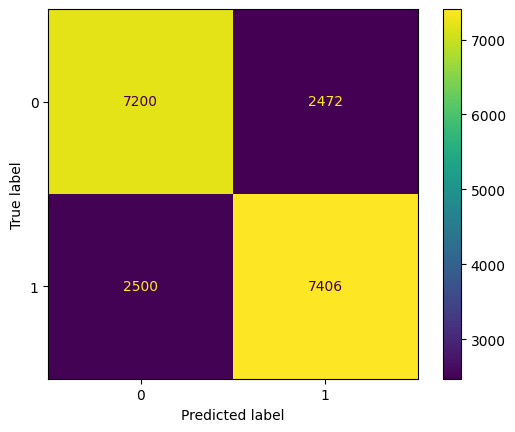

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      9672
           1       0.75      0.75      0.75      9906

    accuracy                           0.75     19578
   macro avg       0.75      0.75      0.75     19578
weighted avg       0.75      0.75      0.75     19578



In [169]:

# Dividir los datos en conjuntos de entrenamiento y prueba

from xgboost import DMatrix, train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain = DMatrix(X_train_scaled, label=y_train)
dtest = DMatrix(X_test_scaled, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'multi:softmax',  # Para clasificación multiclase
    'num_class': 2,  # Número de clases en la variable de salida
    'eval_metric': 'merror',  # Métrica de evaluación
    'learning_rate': 0.1,
    'max_depth': 5
}

# Entrenar el modelo XGBoost
num_rounds = 300

xgb_model = train(params, dtrain, num_rounds)

# Hacer predicciones
y_pred_xgb = xgb_model.predict(dtest)

# Evaluar el modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy (XGBoost): {accuracy_xgb}')
scores["Random Forest (XGBoost)"] = accuracy_score(y_test, y_pred_xgb)


# # Print classification report
# print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, y_pred_xgb))


In [170]:
# print(f"Columnas dropear {dropear}")
# print(f"random forest: {round(random_forest_accuracy*100, 3)}")
# print(f"linear reg   : {round(linear_reg_accuracy*100, 3)}" )
# print(f"xgboost      : {round(xgboost_accuracy*100, 3)}"  )

print(scores)

{'Logistic Regression': 0.7220088264138608, 'Random Forest Classifier': 0.7412553121935272, 'HistGradientBoostingClassifier': 0.7430532853873815, 'Random Forest 2': 0.7425220660346519, 'Logistic Regression 2': 0.7231586474614363, 'Random Forest (XGBoost)': 0.7460414751251405}


In [171]:
# df_reviews = pd.read_parquet(r'Datawarehouse\reviewstexto.parquet')


- accesibilidad 10 columnas, 5 de yelp y 5 de google, (lift - elevator)
- beer - alcohol
- one hot encoding o level encoding a los estados
- crowd, family friend
- reseña, cloud, variables de peso
- balanceo de la variable target, min max scaler
- mapa mental de las categorías nuevas
- qué nuevos valores del ML agregar al Dashboard
- subir al datawarehouse las nuevas categorías


In [172]:
# import optuna
# import xgboost as xgb
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Asumiendo que X y y ya están definidos

# # Escalar todo el dataset
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# def objective(trial):
#     params = {
#         'objective': 'multi:softmax',
#         'num_class': 2,
#         'eval_metric': 'merror',
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.01, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500)
#     }

#     xgb_model = xgb.XGBClassifier(**params)

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(xgb_model, X_scaled, y, cv=cv, scoring='accuracy')
#     return scores.mean()

# # Crear el estudio y optimizar los hiperparámetros
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Imprimir los mejores parámetros encontrados por Optuna
# print(f'Best trial: {study.best_trial.value}')
# print(f'Best parameters: {study.best_trial.params}')

# # Entrenar el modelo final con los mejores parámetros
# best_params = study.best_trial.params
# xgb_model = xgb.XGBClassifier(**best_params)
# xgb_model.fit(X_scaled, y)

# # Hacer predicciones en el mismo conjunto para obtener la matriz de confusión y el informe de clasificación
# y_pred_xgb = xgb_model.predict(X_scaled)

# # Matriz de confusión
# cm = confusion_matrix(y, y_pred_xgb)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()

# # Informe de clasificación
# print(classification_report(y, y_pred_xgb))


In [173]:
# %pip install ipywidgets widgetsnbextension pandas-profiling

In [174]:
# %pip install optuna

In [175]:
X

,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair-accessible entrance,amen_Bar onsite,amen_Good for kids,amen_High chairs,amen_Restroom,amen_Wi-Fi,...,id_estado_41,id_estado_42,id_estado_43,id_estado_44,id_estado_45,id_estado_46,id_estado_47,id_estado_48,id_estado_49,id_estado_50
19852,1,0,1,1,0,0,1,1,1,0,...,0,1,0,0,0,0,0.0,0.0,0.0,0.0
16455,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
103747,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
92468,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.0,0.0,0.0,0.0
81947,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111901,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
111904,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
111905,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
111908,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


InvalidIndexError: (slice(None, None, None), 0)

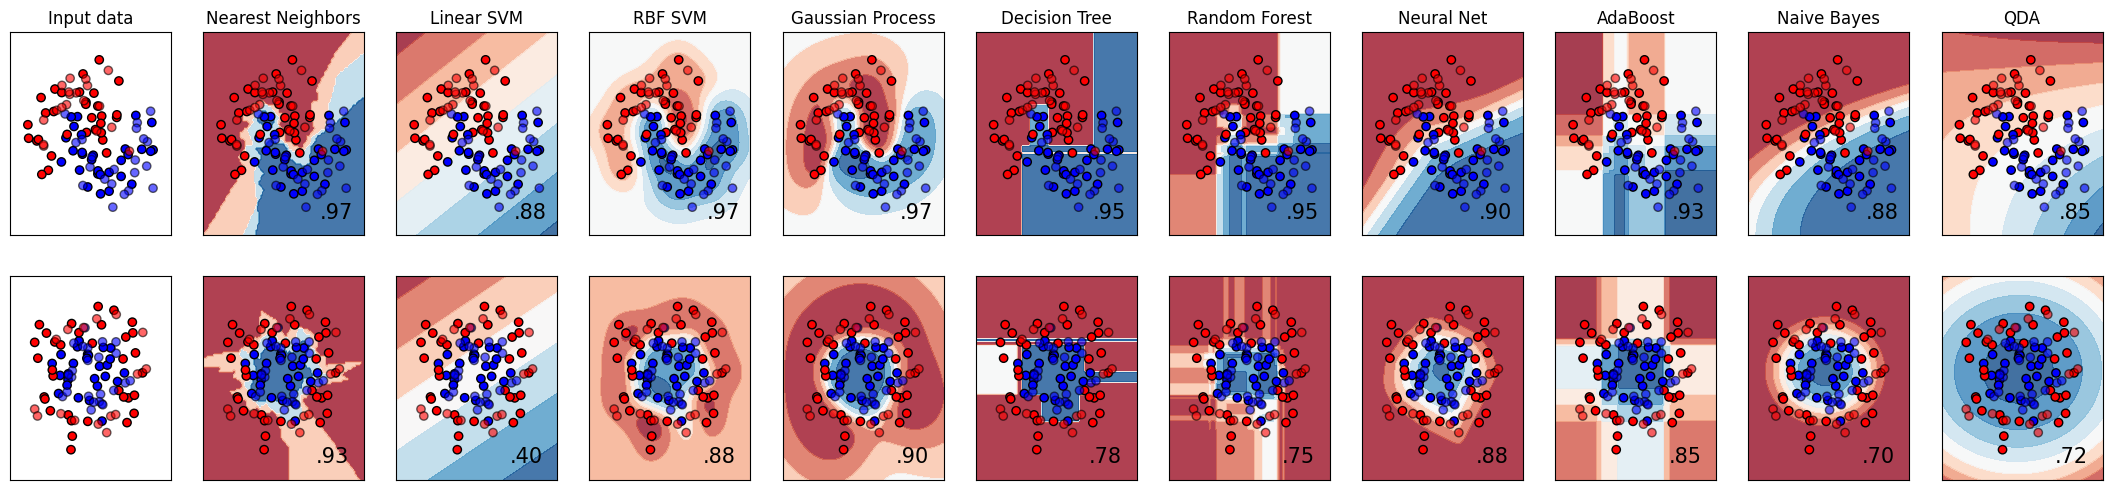

In [176]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# X, y = make_classification(
#     n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
# )
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()